# **Data Science Project**
by [Gustavo R Santos](https://www.linkedin.com/in/gurezende/)

---

### Predicting fraud on credit card transactions

#### Project Description:
This is a classic classification project in Data Science where a dataset from 2013 with 284,807 transactions containing 492 frauds is provided. The **purpose** is to work with the data and train a model to predict which transactions are potential frauds or not.

#### Challenges:
The dataset does not bring any named feature. For confidentiality purposes, the data is provided in a normalized form (after PCA) and the variables are numbers (V1, V2, V3...).
The data is highly unbalanced, what will need to be corrected prior to training.

#### Prediction:
The feature *'Class'* is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Imports

In [243]:
from sklearn import model_selection
# Basics
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Undersampling
from imblearn.under_sampling import RandomUnderSampler

# Oversampling
from imblearn.over_sampling import SMOTE 

# Grid Search
from sklearn.model_selection import GridSearchCV

# Machine Learning
from sklearn.model_selection import cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix	
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Python Versions
from platform import python_version
print(f'Using python version {python_version()}')
print(f'Using pandas version {pd.__version__}')
print(f'Using seaborn version {sns.__version__}')

Using python version 3.7.13
Using pandas version 1.3.5
Using seaborn version 0.11.2


## Dataset
You can find this dataset in the following [link](https://tinyurl.com/ypm4wx4n).

The dataset contains transactions made by credit cards in September 2013 by European cardholders.The transactions occurred in two days, where we have 262 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. 
* Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
* Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
* The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes **value 1 in case of fraud** and **0 if not fraud**.

In [3]:
# Load the dataset
path = '/content/creditcard.csv'
df = pd.read_csv(path)

# View head
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
# Check dataset shape and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**`Analysis`**: 

The data has all the 284,807 transactions with 31 *numeric* columns and **no null values found** (all 'non-null values are the same as the row count). That is a good start.

As this data is normalized with PCA, there's not much information we can take from a statistical description of the dataset. The columns Amount, Time and Class can maybe give us some insights.

## Exploratory Analysis

In [5]:
# Statistical description of Time, Class and Amount
df[ ['Time', 'Class', 'Amount'] ].describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,94813.859575,47488.145955,0.0,54201.5,84692.0,139320.500,172792.00
Class,284807.0,0.001727,0.041527,0.0,0.0,0.0,0.000,1.00
Amount,284807.0,88.349619,250.120109,0.0,5.6,22.0,77.165,25691.16


**`Analysis`**: 

* For *Time*, as the max is on the 172k range and the mean is at 94k, it shows me that the majority of the transactions are on the second day of the data extraction.
* The mean of *Class* very close to zero already shows the imbalance of the dataset, what we will confirm later.
* There are outliers in *Amount*. A \$25k transaction on a dataset with $22 median points that. 

#### Do we have more frauds for higher or lower Amounts spent?

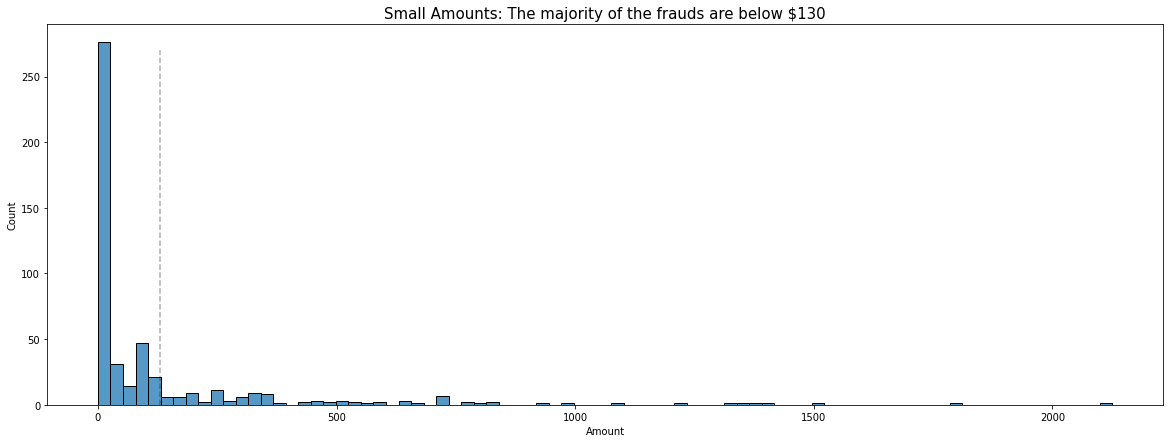

In [6]:
# Slice data
frauds = df.query('Class == 1')

# Setup figure
plt.figure(figsize=(20,7))

# Plot
sns.histplot(data = frauds, x='Amount')
# Reference line
plt.vlines(x= 130, ymin=0, ymax=270, linestyles='--', alpha=.3)
plt.title('Small Amounts: The majority of the frauds are below $130', size=15);

**`Analysis`**: 
It looks like NOT. The majority of the frauds are below $130.

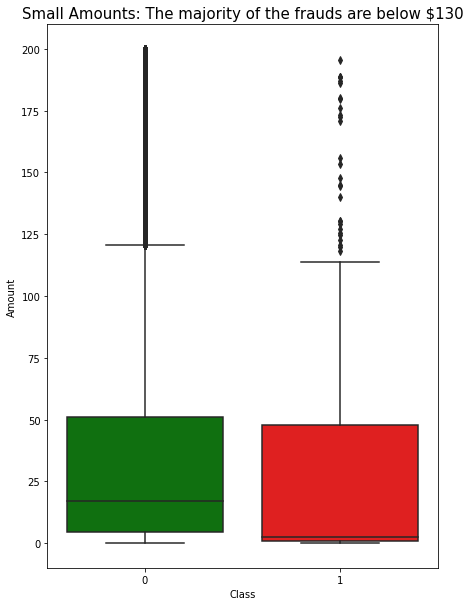

In [7]:
# Slice data
frauds = df.query('Class == 1')

# Setup figure
plt.figure(figsize=(7,10))

# Plot
my_pal = {0: 'green', 1:'red'}
sns.boxplot(data = df.query('Amount < 200'), x='Class', y='Amount', palette= my_pal)

plt.title('Small Amounts: The majority of the frauds are below $130', size=15);

### Can we see any pattern of Frauds vs Time?

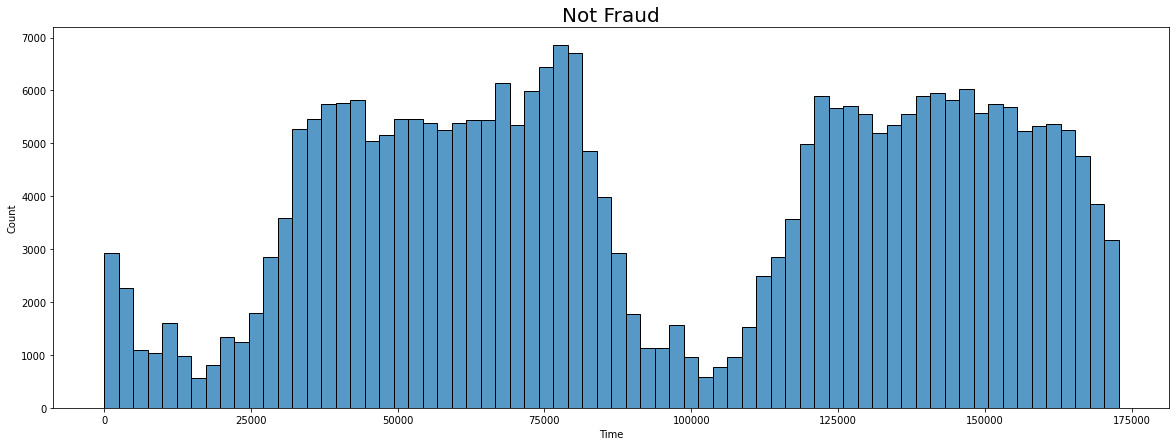

In [8]:
# Setup figure
plt.figure(figsize=(20,7))

# Plot
sns.histplot(data = df.query('Class == 0'), x='Time', bins=70)
plt.title('Not Fraud', size=20);

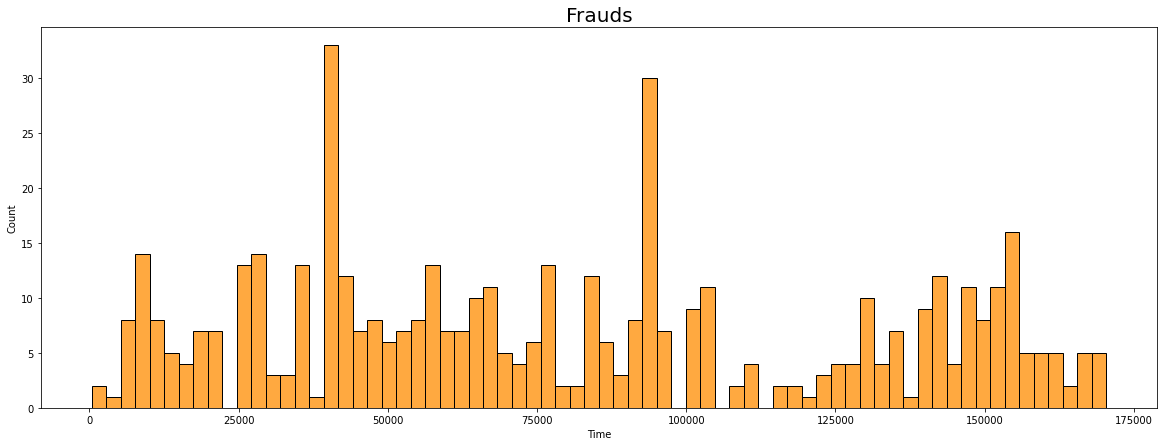

In [9]:
# Setup figure
plt.figure(figsize=(20,7))

# Plot
sns.histplot(data = frauds, x='Time', color='darkorange', bins=70)
plt.title('Frauds', size=20);

**`Analysis`**: 
As we have more transactions, more frauds appear, what makes sense.

There is no much more we can do to explore this data as it brings only transformed variables.
But let's look at the categories graphic and visualy see the unbalance.

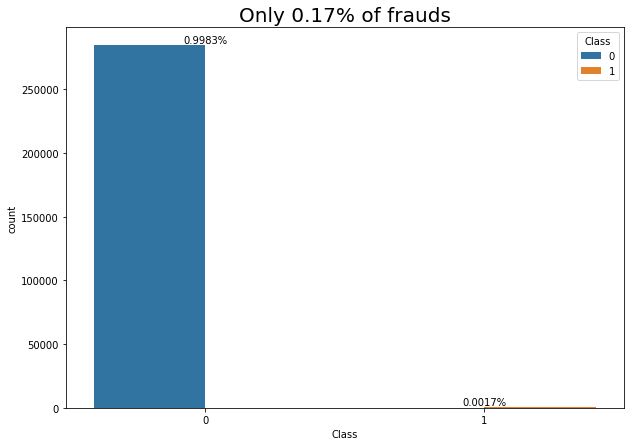

In [10]:
# Setup figure
plt.figure(figsize=(10,7))

# Check imbalance
sns.countplot(data=df, x='Class', hue='Class')
for i in [0,1]:
  plt.annotate(f'{round(df.Class.value_counts(normalize=True)[i],4)}%',
               xy=( i , df.Class.value_counts()[i]+2000),
               ha='center')
  plt.title('Only 0.17% of frauds', size=20);

## Scale Variables

Before we move to the imbalance correction, let's scale the variables Time and Amount to make sure those are in the same scale of the rest of the dataset. That will help the algorithm to correctly identify the frauds.

In [232]:
# Create a copy of the dataset for scaling
df_scaled = df.copy()

# Scaler instance
scaler = StandardScaler()

# Standardize the data
# Add the scaled variables to the dataset
df_scaled['time_scaled'] = scaler.fit_transform(df_scaled[['Time']])
df_scaled['amount_scaled'] = scaler.fit_transform(df_scaled[['Amount']])

# Drop non-scaled variables from the dataset
df_scaled.drop(['Time', 'Amount'], axis=1, inplace=True)

df_scaled.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,time_scaled,amount_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.996583,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.996583,-0.342475


In [233]:
# Predictors (X) and Response (y)
X = df_scaled.drop('Class', axis=1)
y = df_scaled['Class']

## Imbalance

For classification problems, a balanced dataset is crucial because the algorithm will learn according to what's presented to it. If we present 99% of non-fraud transactions, the model will not be able to learn what differentiates a fraudulent operation and will not be able to generalize well.

Another good point to make is that with this highly unbalanced data, you can be fooled by the results. Let's think this through for a moment: if we classify all of our transactions as non-fraud, we would still be getting a 99% of accuracy and Precision, but our Recall will be terrible. I won't find any frauds.

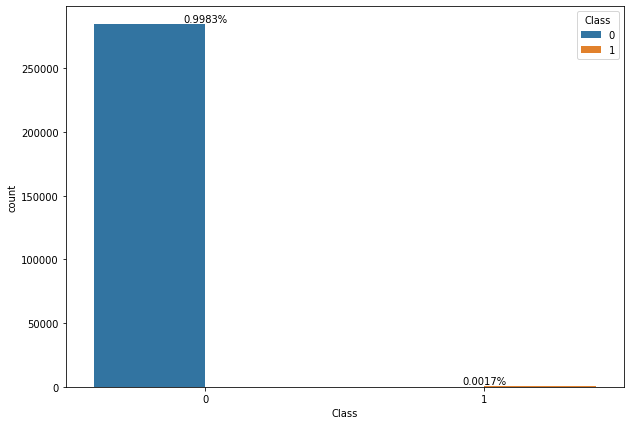

In [234]:
# Setup figure
plt.figure(figsize=(10,7))

# Check imbalance
sns.countplot(data=df_scaled, x='Class', hue='Class')
for i in [0,1]:
  plt.annotate(f'{round(df_scaled.Class.value_counts(normalize=True)[i],4)}%',
               xy=( i , df_scaled.Class.value_counts()[i]+2000),
               ha='center');

To deal with that problem, let's use two techniques for over sampling the minority Class and the Under Sampling for the majority Class.

[imblearn.org](https://imbalanced-learn.org/stable/introduction.html)

### Oversampling
- Oversampling: Increase the number of observations from the minority class using an algorithm that creates observations that are similar to the minority class, aiming to balance both classes.
- The oversampling will create observations for the minority class at an amount equal to 10% of the total of the dataset.

In [235]:
sm = SMOTE(random_state=0, sampling_strategy= 0.10)

X_train_oversampled, y_train_oversampled = sm.fit_resample(X, y)

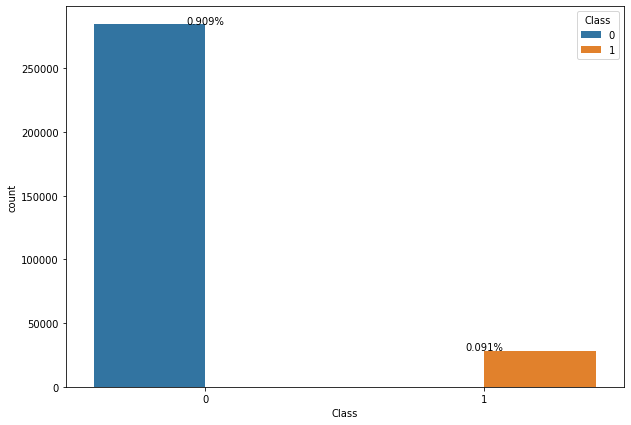

In [236]:
# Gather train dataset
df_train = pd.concat([X_train_oversampled, y_train_oversampled], axis=1)

# Setup figure
plt.figure(figsize=(10,7))

# Check imbalance
sns.countplot(data=df_train, x='Class', hue='Class')
for i in [0,1]:
  plt.annotate(f'{round(df_train.Class.value_counts(normalize=True)[i],3)}%',
               xy=( i , df_train.Class.value_counts()[i]),
               ha='center');

In [237]:
# Numbers after oversampling
df_train.Class.value_counts()

0    284315
1     28431
Name: Class, dtype: int64

### Undersampling

- Undersampling: Reduce the number of observations of the majority class using statistical sampling.
- Now, after increasing the number of observations from the minority class, let's combine that with the undersampling and decrease the size of the majority class, as it is still very big.

Combining both methods will help us to get better results. If we use only undersampling, the traning dataset becomes too small. If we use only the oversampling in this case, the number of synthetic observations will be too large, increasing the risk of creating bad data and, consequently, bad training.

In [193]:
#from imblearn.under_sampling import NearMiss
#nm = NearMiss()

#X_train_overunder, y_train_overunder = nm.fit_resample(X_train_oversampled, y_train_oversampled)

In [238]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=0)
X_train_overunder, y_train_overunder = rus.fit_resample(X_train_oversampled, y_train_oversampled)

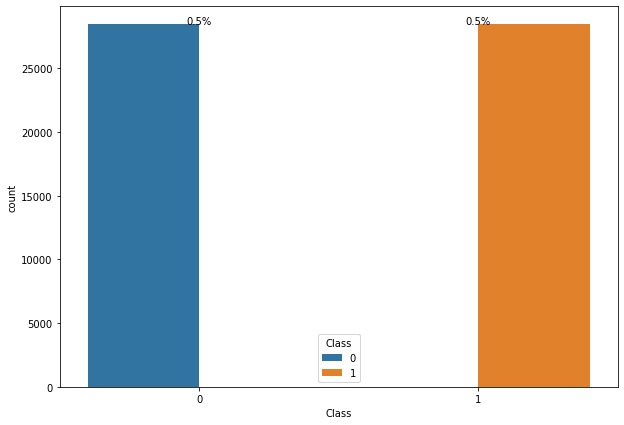

In [239]:
# Gather train dataset
df_train = pd.concat([X_train_overunder, y_train_overunder], axis=1)

# Setup figure
plt.figure(figsize=(10,7))

# Check imbalance
sns.countplot(data=df_train, x='Class', hue='Class')
for i in [0,1]:
  plt.annotate(f'{round(df_train.Class.value_counts(normalize=True)[i],3)}%',
               xy=( i , df_train.Class.value_counts()[i]),
               ha='center');

In [240]:
# Numbers after undersampling
df_train.Class.value_counts()

0    28431
1    28431
Name: Class, dtype: int64

## Train Test Split

In [241]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_train_overunder, y_train_overunder, test_size=0.2, random_state=12)

print(f'X: \n{X_train.shape, X_test.shape}')
print(f'y: \n{y_train.shape, y_test.shape}')

X: 
((45489, 30), (11373, 30))
y: 
((45489,), (11373,))


## Modeling

In [256]:
# Create list of algorithms instances to be tested for selection
models = [ ('Logistic Regression', LogisticRegression()),
           ('Decision Tree', DecisionTreeClassifier()),
           ('Random Forest', RandomForestClassifier()),
           ('XGB', GradientBoostingClassifier()) ]

For a list of metrics available for `cross_validate()`, refer to [sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) or run the code below:

```
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())
```

In [258]:
# Create list to store results
results =[]
names = []

# Test 4 models
for name, model in models:
  cv = cross_validate(model, X_train, y_train, cv=5 ,scoring=['precision', 'recall', 'f1'], return_estimator=True) 
  results.append(cv)
  names.append(name)
  print(f'+ Model : {name}')
  print(f'F1: {np.mean(cv["test_f1"]).round(3)} | Std: {np.std(cv["test_f1"]).round(3)} ')
  print(f'Precision: {np.mean(cv["test_precision"]).round(3)} | Std: {np.std(cv["test_precision"]).round(3)} ')
  print(f'Recall: {np.mean(cv["test_recall"]).round(3)} | Std: {np.std(cv["test_recall"]).round(3)} ')
  print('--------------------')

+ Model : Logistic Regression
F1: 0.945 | Std: 0.001 
Precision: 0.973 | Std: 0.004 
Recall: 0.918 | Std: 0.001 
--------------------
+ Model : Decision Tree
F1: 0.984 | Std: 0.0 
Precision: 0.98 | Std: 0.001 
Recall: 0.988 | Std: 0.0 
--------------------
+ Model : Random Forest
F1: 0.996 | Std: 0.0 
Precision: 0.998 | Std: 0.0 
Recall: 0.995 | Std: 0.001 
--------------------
+ Model : XGB
F1: 0.975 | Std: 0.001 
Precision: 0.984 | Std: 0.002 
Recall: 0.966 | Std: 0.001 
--------------------


**`Analysis`**: The measure used here was area under the curve and it was performed a cross validation for better results. The *Logistic Regression* and the *Decision Tree* presented a good performance, around 99%.

The ensemble models such as *Random Forest* and *Extreme Gradient Boost* returned a better performance, however we must be careful with **RF** regarding overfitting, as the result is too close to 100% F1. 

I will build a tunned model using Random Forest, trying to reduce the overfitting and will also build a XGBoost to better compare and select a final model for predictions.

### Random Forest

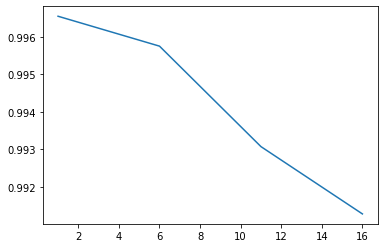

In [261]:
# List
scores = []
# Test values of minimum samples per leaf
for min_sample in range(1,21,5):
  # Model
  rf_model = RandomForestClassifier(n_estimators=10, min_samples_leaf= min_sample, random_state=12).fit(X_train, y_train)
  y_hat = rf_model.predict(X_test)
  scores.append( f1_score(y_test, y_hat) )

# Plot
sns.lineplot(x=range(1,21,5), y=scores)

In [262]:
# Instanciate the model
rf_model = RandomForestClassifier(n_estimators=50, min_samples_leaf= 15, random_state=12)
# Fit
rf_model.fit(X_train, y_train)

# Predict
preds_rf = rf_model.predict(X_test)

print(classification_report(y_test, preds_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5717
           1       1.00      0.99      0.99      5656

    accuracy                           0.99     11373
   macro avg       0.99      0.99      0.99     11373
weighted avg       0.99      0.99      0.99     11373



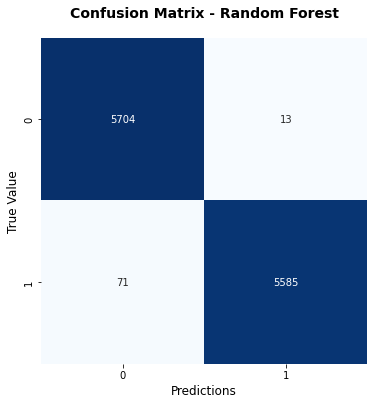

In [286]:
# Confusion Matrix RF
plt.figure(figsize=(6,6))
matriz_rf = confusion_matrix(y_test, preds_rf)
sns.heatmap(matriz_rf, square=True, annot=True, fmt='.0f', cbar=False, cmap= 'Blues')

plt.title('Confusion Matrix - Random Forest',
          fontsize = 14,
          pad= 20, 
          fontweight= 'bold')

plt.xlabel('Predictions',fontsize = 12)
plt.ylabel('True Value'  ,fontsize = 12)

plt.show()

### XGBoost

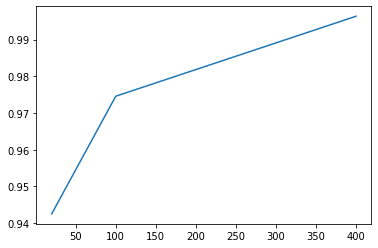

In [277]:
# List
scores = []
# Test values of minimum samples per leaf
for est in [20, 100, 400]:
  # Model
  gb_model = GradientBoostingClassifier(n_estimators=est, random_state= 12).fit(X_train, y_train)
  y_hat = gb_model.predict(X_test)
  scores.append( f1_score(y_test, y_hat) )

# Plot
sns.lineplot(x=[20, 100, 400], y=scores)

In [278]:
# Gradient Boost Model instance and fit
gb_model = GradientBoostingClassifier(n_estimators=300, random_state= 12).fit(X_train, y_train)

In [279]:
preds_gb = gb_model.predict(X_test)

# Results report
print(classification_report(y_test, preds_gb))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5717
           1       0.99      1.00      0.99      5656

    accuracy                           0.99     11373
   macro avg       0.99      0.99      0.99     11373
weighted avg       0.99      0.99      0.99     11373



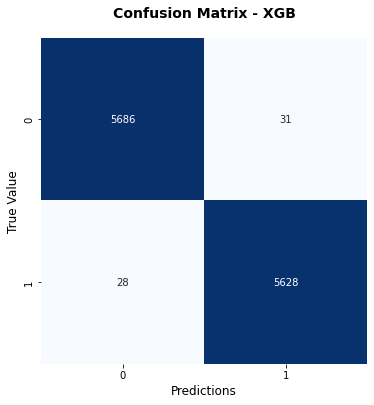

In [287]:
# Confusion Matrix XGB
plt.figure(figsize=(6,6))
matriz_gb = confusion_matrix(y_test, preds_gb)
sns.heatmap(matriz_gb, square=True, annot=True, fmt='.0f', cbar=False, cmap= 'Blues')

plt.title('Confusion Matrix - XGB',
          fontsize = 14,
          pad= 20, 
          fontweight= 'bold')

plt.xlabel('Predictions',fontsize = 12)
plt.ylabel('True Value'  ,fontsize = 12)

plt.show()

## Evaluating the Models

In [288]:
# Create Dataframe
pd.DataFrame({'Random Forest':{'Precision': precision_score(y_test, preds_rf), 'Recall':recall_score(y_test, preds_rf), 'F1': f1_score(y_test, preds_rf), 'Type 1 Error': matriz_rf[0,1], 'Type 2 Error': matriz_rf[1,0]},
              'XGB':{'Precision': precision_score(y_test, preds_gb), 'Recall':recall_score(y_test, preds_gb), 'F1': f1_score(y_test, preds_gb), 'Type 1 Error': matriz_gb[0,1], 'Type 2 Error': matriz_gb[1,0]}
              })

,Random Forest,XGB
Precision,0.997678,0.994522
Recall,0.987447,0.995050
F1,0.992536,0.994786
Type 1 Error,13.000000,31.000000
Type 2 Error,71.000000,28.000000


**`Analysis`**: The models are giving very similar results, with XGB performing slightly better. Therefore, that will be the final model chosen.

## Conclusion

The project started from a very unbalanced dataset, where we hd to find the frauds within a very far majority of regular transactions.

After some formatting and balancing the dataset, it became much easier for the algorithm to find the transactions that had a different pattern than expected, pointing us to the frauds.

The final model presented over 99% of F1 in the test set, so a great balance between Precision (from the transactions classified as fraud, 99.4% were actually frauds) and Recall (from all the frauds, we were able to find 99.5%).

For this type of project, our intention is to minimize the Type 2 error, when we fail to stop a fraudulent transaction over the Type 1, which is to stop a regular transaction as fraud.

The **XGB** model had only 28 fraudulent transactions that were not stopped against 71 from the RF model.